## Demo: Dataset with mixed numerical and categorical features (KDD cup '99)

This Notebook demonstrates several outlier techniques used on the KDD cup dataset, and how these results are submitted to the API.

Labels (y_kdd) are available to explore the effectiveness of the various strategies. 



In [6]:
# standard library imports
import os
import sys
from collections import Counter

# pandas, seaborn etc.
import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# sklearn outlier models
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# other sklearn functions
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale as preproc_scale

# pyod
import pyod
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN   

sys.path.append("..") #to enable importing from ../outlierutils


In [7]:
from outlierutils import plot_top_N, plot_outlier_scores, LabelSubmitter

In [8]:
?preproc_scale

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data

In [12]:
data_path = '../data/'
#x_kdd = pd.read_pickle(os.path.join(data_path, 'x_kdd.pkl'))
#y_kdd = pd.read_pickle(os.path.join(data_path, 'y_kdd.pkl'))

x_kdd = pd.read_pickle(os.path.join(data_path, 'x_kdd_prepared.pkl'))
y_kdd = pd.read_pickle(os.path.join(data_path, 'y_kdd_prepared.pkl'))

print('Shape of the X-data: {}'.format(x_kdd.shape))
print('Mean of the y variable: {:.3%}'.format(y_kdd.mean()))

Shape of the X-data: (48113, 79)
Mean of the y variable: 0.416%


In [14]:
# Drop columns with zero variance
zerovar_cols = list(x_kdd.var()[x_kdd.var()==0].index)
x_kdd = x_kdd.drop(columns=zerovar_cols)


In [15]:
assert not x_kdd.duplicated().sum(), 'Duplicates detected!!'

In [16]:
x_kdd.describe().iloc[:, :20]

,protocol_type = udp,protocol_type = tcp,protocol_type = icmp,service = private,service = domain_u,service = http,service = smtp,service = ftp_data,service = ftp,service = eco_i,service = other,service = auth,service = ecr_i,service = IRC,service = X11,service = finger,service = time,service = telnet,service = ntp_u,service = tim_i
count,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.00000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000
mean,0.078773,0.915428,0.005799,0.023382,0.054455,0.812130,0.066614,0.022031,0.002744,0.001018,0.002141,0.00185,0.003513,0.000436,0.000083,0.003616,0.000499,0.002390,0.001289,0.000125
std,0.269387,0.278246,0.075930,0.151116,0.226916,0.390613,0.249355,0.146787,0.052307,0.031897,0.046220,0.04297,0.059163,0.020888,0.009118,0.060029,0.022329,0.048832,0.035875,0.011167
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
print('Minimum, all data points: {}'.format(x_kdd.min().min()))
print('Maximum, all data points: {}'.format(x_kdd.max().max()))


Minimum, all data points: 0.0
Maximum, all data points: 1.0


Note that the data are already nicely scaled between 0 and 1 and need no futher pre-processing

### 1. KNN

In [18]:
# train kNN detector
first_N = 20000
clf_name = 'KNN'
clf = KNN(method='median', n_neighbors=83)
clf.fit(x_kdd.head(first_N))

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores


**Submit to the API**

In [19]:
url = "https://unsupervised-label-api-pg.herokuapp.com/"

ls_ernst = LabelSubmitter(username='ernst', 
                           password='2718_', 
                           url=url)
ls_ernst.get_jwt_token()

In [20]:
N = 500
top_N_kdd = np.argsort(y_train_scores)[::-1][:N]


In [21]:
ls_ernst.post_predictions(top_N_kdd, endpoint='kdd')

submitted 500 new points
number of positives in submission: 74
precision of submission: 14.80%


In [22]:
labels = ls_ernst.get_labels(endpoint='kdd')

number of predictions made: 500
total number of positives found: 74
total precision: 14.80%


,N_submitted,N_positives_found,precision
admin,0.0,0.0,NaN
steffen,0.0,0.0,NaN
alessandro,0.0,0.0,NaN
theo,0.0,0.0,NaN
giulio,0.0,0.0,NaN
ernst,500.0,74.0,14.8
test,0.0,0.0,NaN


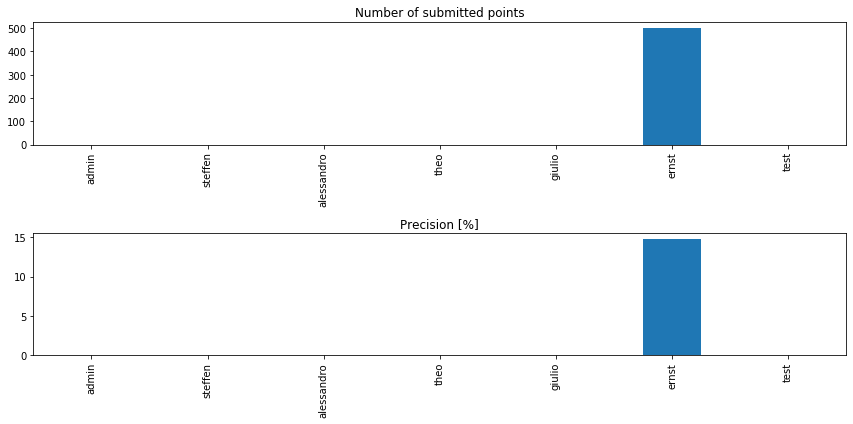

In [25]:
ls_ernst.get_statistics(endpoint='kdd')

## 2. Isolation Forest

In [26]:
ifo = IsolationForest(n_estimators=100, max_samples=1024, random_state=1, contamination=0.01, behaviour='new')
ifo.fit(x_kdd)
kdd_isof_scores = - ifo.decision_function(x_kdd)

In [112]:
ls_test = LabelSubmitter(username='test', 
                           password='2718_', 
                           url=url)
ls_test.get_jwt_token()

In [113]:
N = 500
top_N_kdd_iso = np.argsort(kdd_isof_scores)[::-1][:N]


In [114]:
ls_test.post_predictions(top_N_kdd_iso, endpoint='kdd')

submitted 500 new points
number of positives in submission: 144
precision of submission: 28.80%


,N_submitted,N_positives_found,precision
admin,0.0,0.0,NaN
steffen,0.0,0.0,NaN
alessandro,0.0,0.0,NaN
theo,0.0,0.0,NaN
giulio,0.0,0.0,NaN
ernst,0.0,0.0,NaN
test,500.0,144.0,28.8


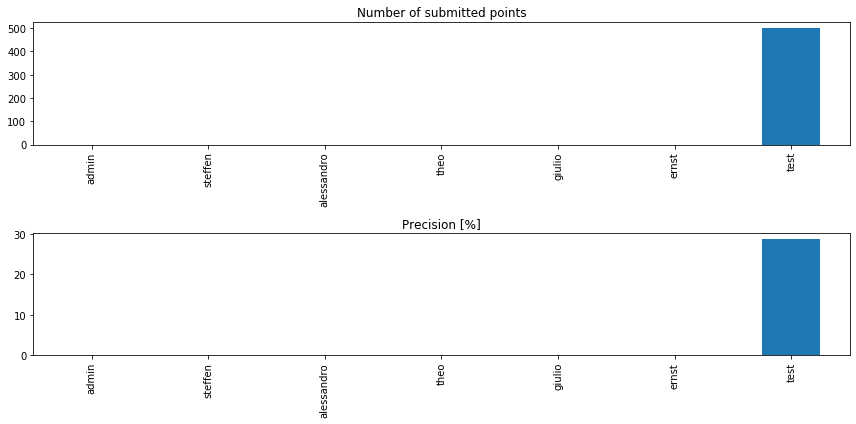

In [115]:
ls_ernst.get_statistics(endpoint='kdd')

## 3. Autoencoder

In [27]:
# To have more control, we pass an optimizer
from keras.optimizers import Adam
adam = Adam(learning_rate=1.E-4)

In [28]:
# Note that the preprocessing in the AutoEncoder is using the StandardScaler. 
# Let's scale the data ourselves
#scaler = MinMaxScaler()
scaler = RobustScaler(quantile_range=(2, 98))
#scaler = StandardScaler()
x_kdd_scaled = scaler.fit_transform(x_kdd)

In [29]:
x_kdd.iloc[:, [41, 42, 43, 72, 73, 74, 75, 76]].describe()

,duration,src_bytes,dst_bytes,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000
mean,0.000251,0.000147,0.000864,0.019695,0.003301,0.002434,0.004722,0.002530
std,0.011092,0.006112,0.007812,0.035692,0.048284,0.044497,0.052027,0.042909
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000034,0.000064,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000040,0.000221,0.010000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000050,0.000655,0.030000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
clf = AutoEncoder(
    hidden_neurons=[30, 20, 30],
    hidden_activation='elu',
    output_activation='linear',
    optimizer=adam,
    epochs=20,
    batch_size=16,
    dropout_rate=0.2,
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=False,
    verbose=1,
    random_state=1,
    contamination=0.1,
)

In [31]:
clf.fit(x_kdd)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 77)                6006      
_________________________________________________________________
dropout_1 (Dropout)          (None, 77)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 77)                6006      
_________________________________________________________________
dropout_2 (Dropout)          (None, 77)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                2340      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)               

AutoEncoder(batch_size=16, contamination=0.1, dropout_rate=0.2, epochs=20,
      hidden_activation='elu', hidden_neurons=[30, 20, 30],
      l2_regularizer=0.0,
      loss=<function mean_squared_error at 0x7f5611f11d90>,
      optimizer=<keras.optimizers.Adam object at 0x7f56106bd9e8>,
      output_activation='linear', preprocessing=False, random_state=1,
      validation_size=0.1, verbose=1)

In [32]:
y_train_scores = clf.decision_scores_  # raw outlier scores
y_train_scores = np.clip(y_train_scores, 0, 50) # for visual purposes

In [33]:
positive_idx = list(y_kdd[y_kdd==1].index)[:3]
negative_idx = list(y_kdd[y_kdd==0].index)[:3]


In [34]:
negative_idx

[0, 1, 2]

**Visualize the Autoencoder reconstruction**

In [227]:
# Compare the original with the reconstruction to get a feeling (in StandardScaled space)
def show_reconstruction(clf, data, index, ax, title=''):
    if isinstance(data, pd.DataFrame):
        data = data.values
    data_recon = clf.model_.predict(data[[index], :])
    ax.plot(data[index, :], label='original')
    ax.plot(data_recon[0, :], label='reconstructed', linestyle='--');
    ax.legend()
    ax.set_title(title);

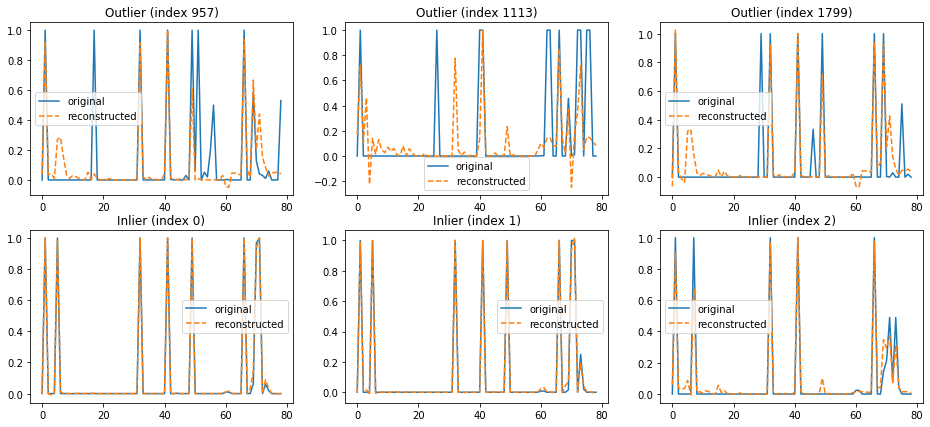

In [236]:
fig, axs = plt.subplots(2, 3, figsize=(16, 7))
titles = ['Outlier', 'Inlier']
for i, idxs in enumerate([positive_idx, negative_idx]):
    for j, idx in enumerate(idxs):
        show_reconstruction(clf, x_kdd, index=idx, ax=axs[i, j], title=titles[i]  + f' (index {idx})'
                            )

**Visualize the mean difference between the two classes**

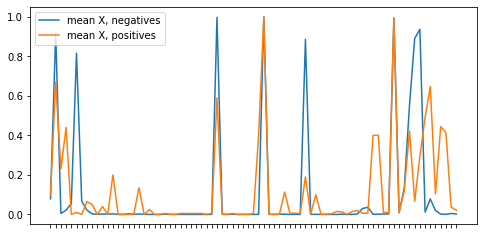

In [249]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x_kdd.loc[y_kdd==0, :].mean(axis=0), label='mean X, negatives')
ax.plot(x_kdd.loc[y_kdd==1, :].mean(axis=0), label='mean X, positives');
ax.set_xticklabels([])
ax.legend();


Object `ax.set_xaxis_off` not found.


In [35]:
ls_steffen = LabelSubmitter(username='steffen', 
                           password='2718_', 
                           url=url)
ls_steffen.get_jwt_token()

In [42]:
N = 1000
top_N_kdd_autoenc = np.argsort(y_train_scores)[::-1][:N]
ls_steffen.post_predictions(top_N_kdd_autoenc, endpoint='kdd')

submitted 500 new points
number of positives in submission: 170
precision of submission: 17.00%


,N_submitted,N_positives_found,precision
admin,0.0,0.0,NaN
steffen,1000.0,170.0,17.0
alessandro,0.0,0.0,NaN
theo,0.0,0.0,NaN
giulio,0.0,0.0,NaN
ernst,500.0,74.0,14.8
test,0.0,0.0,NaN


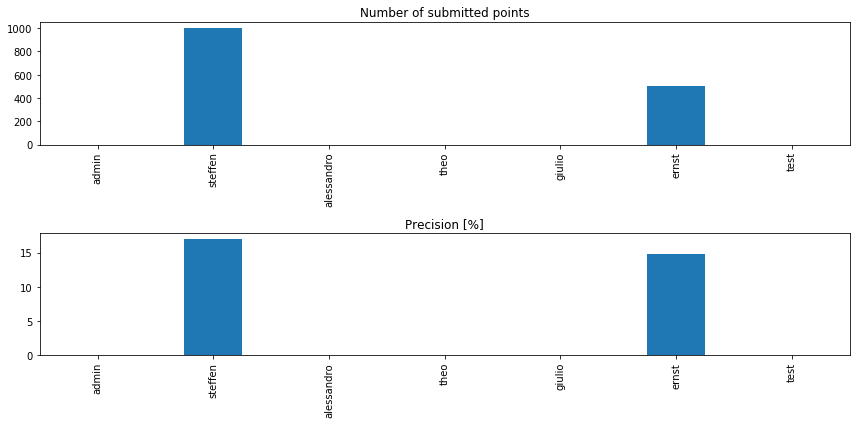

In [43]:
ls_steffen.get_statistics(endpoint='kdd')

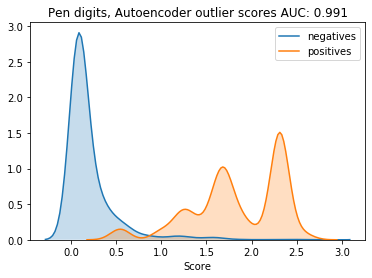

In [250]:
res = plot_outlier_scores(y_kdd_prepared.values, y_train_scores, 
                          bw=0.1, title='Pen digits, Autoencoder outlier scores')

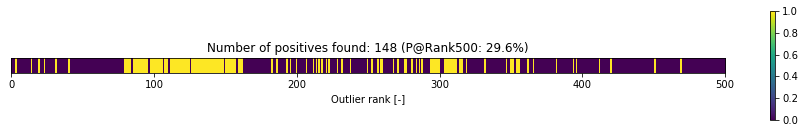

In [253]:
res = plot_top_N(y_kdd_prepared.values, y_train_scores, N=500)